# NEW PORKERS
For this project, we will be conducting an investigation concerning the differences in how local residents and tourists perceive and judge restaurants in New York City, using Yelp data as a proxy for behavior.

To do this, I used the Yelp API to scrape summary data for a large majority of the restaurants in NYC, sweeping through all the designated Yelp restaurant categories and collecting 1000 restaurants for each category to ensure we don't systematically exclude types of restaurants. All non-restaurants and repeating restaurants were subsequently removed.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from yelputils import *
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
sns.set(palette='cubehelix')
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.monospace'] = 'Andale mono'

In [ ]:
r_cats = get_cats('categories.json')
yelp_df(r_cats,'New York City','manhattan.pkl')

### Now that we have all the summary data, let's clean the data!

To do this, we perform several actions:

    1) Remove/fix redundant, unnecessary, or incorrect information
    2) Each restaurant comes with a "list" of categories; one-hot encode these categories
    3) Convert string information into numeric data when relevant
    4) Add borough information based on zip code 

In [330]:
df = pd.read_pickle('manhattan2_open.pkl')
df = df.drop(columns=['image_url','is_closed','display_phone','phone','transactions'])
df = expand_list(df,'categories')
df = df[df['categories'].isin(r_cats)].reset_index(drop=True)
df = pd.concat([df,pd.get_dummies(df['categories'],prefix='cat',dtype='int64')],axis=1)

cats = df.columns[df.columns.str.contains('cat_')]
noncats = df.columns[~df.columns.str.contains('cat_')]

tmp = df.groupby('alias')[cats].sum().reset_index()
df = df.drop_duplicates(subset='alias').reset_index(drop=True)
df = pd.merge(df[noncats],tmp[['alias']+cats.tolist()],on='alias')

for n in range(1,6):
    df.loc[df['price']=='$'*n,'price']=n
    df.loc[df['price']=='£'*n,'price']=n
    
convert_int = ['review_count','zip']
convert_float = ['latitude','longitude','price']
df[convert_int] = df[convert_int].astype('int64')
df[convert_float] = df[convert_float].astype('float64',errors='ignore')

df['borough'] = df['zip'].astype('str')
boroughs = [('100','Manhattan'),('101','Manhattan'),('102','Manhattan'),('104','Bronx'),('112','Brooklyn'),\
            ('113','Queens'),('110','Queens'),('111','Queens'),('114','Queens'),('116','Queens'),\
           ('103','Staten Island')]
for b in boroughs:
    df.loc[df['borough'].str.slice(start=0,stop=len(b[0]))==b[0],'borough'] = b[1]
df = df.loc[~df['borough'].str.contains(r'[0-9]')]
                 
df.to_pickle('nyc_processed.pkl')

print('There are {} unique restaurants extracted from the Yelp API!\n'.format(df.shape[0]))
print('Here is the breakdown of restaurants by borough:\n')
print(df['borough'].value_counts())

There are 18139 unique restaurants extracted from the Yelp API!

Here is the breakdown of restaurants by borough:

Manhattan        8003
Brooklyn         4715
Queens           3890
Bronx             990
Staten Island     541
Name: borough, dtype: int64


Okay, so we have definitely undersampled, as public data suggest that there are around 26K restaurants in NYC, so we've captured around 75% of the restaurants. Next time, we should scrape location in finer detail! However, based on how the Yelp API behaves we should have definitely scraped all the most popular restaraunts. For now though, this should suffice.

### Next, let's print some summary statistics.

In particular, we will focus on getting the distributions of restaurant ratings, review counts and price points

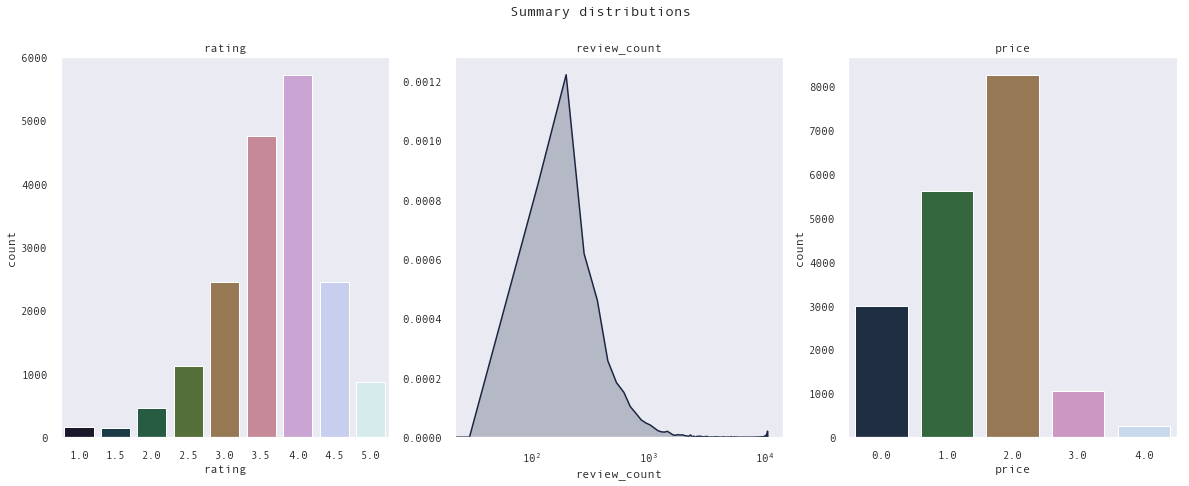

In [335]:
fig,axes = plt.subplots(1,3,figsize=(20,7))
cols = ['rating','review_count','price']
for c,ax in enumerate(axes):
    if c==1:
        sns.distplot(df[cols[c]].fillna(0),ax=ax,kde=True,hist=False,kde_kws={'shade':True}).set_title(cols[c])
        ax.set_xscale('log')
    else:
        colors = sns.cubehelix_palette(n_colors=len(df[cols[c]].unique()))
        sns.countplot(df[cols[c]].fillna(0),ax=ax,palette='cubehelix').set_title(cols[c])
    ax.grid('off')
fig.suptitle('Summary distributions')
plt.show()

Interesting! All of these distributions have a bit of a skewed distribution, and perhaps review counts approaches log normal. Price of 0 indicates no price information. 

### Now, let's check out some of these same properties of restaurants by category

For this, we will aggregate total number of restaurants, average review count, rating and price for each category and rank them. However, because some categories have many more restaurants than others (for example, sandwiches vs. Somalian food), we want our averages to take into account how much uncertainty we have about our estimate. Therefore, we use a bit of a Bayesian approach to calculate the averages: the less information we have for each category, the more our estimate is weighted towards the "prior" -- or the average across all categories.

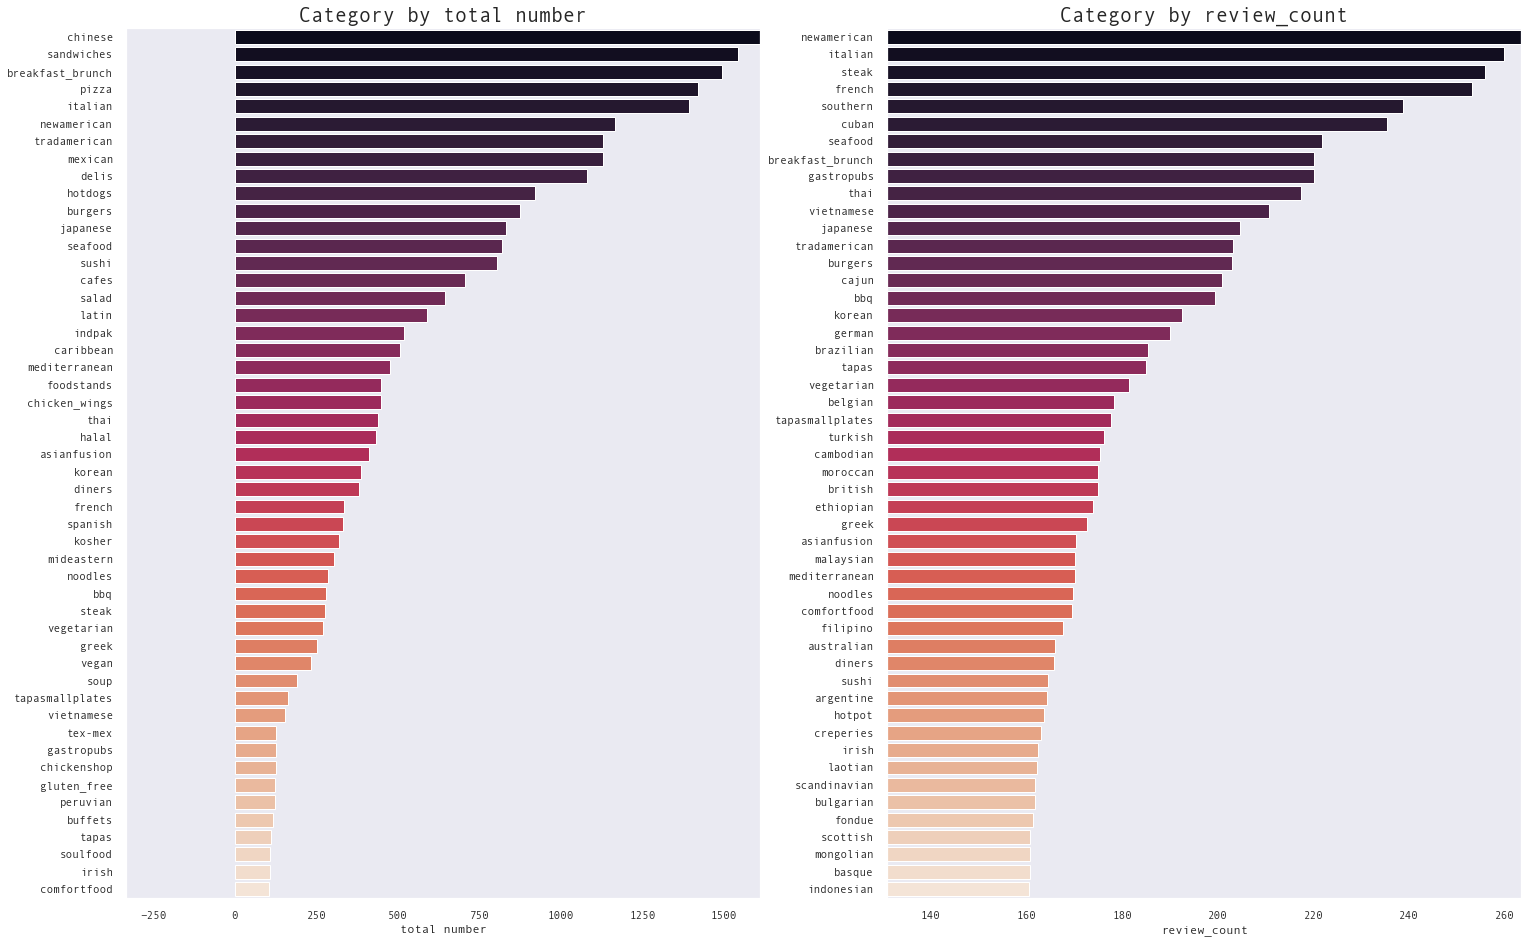

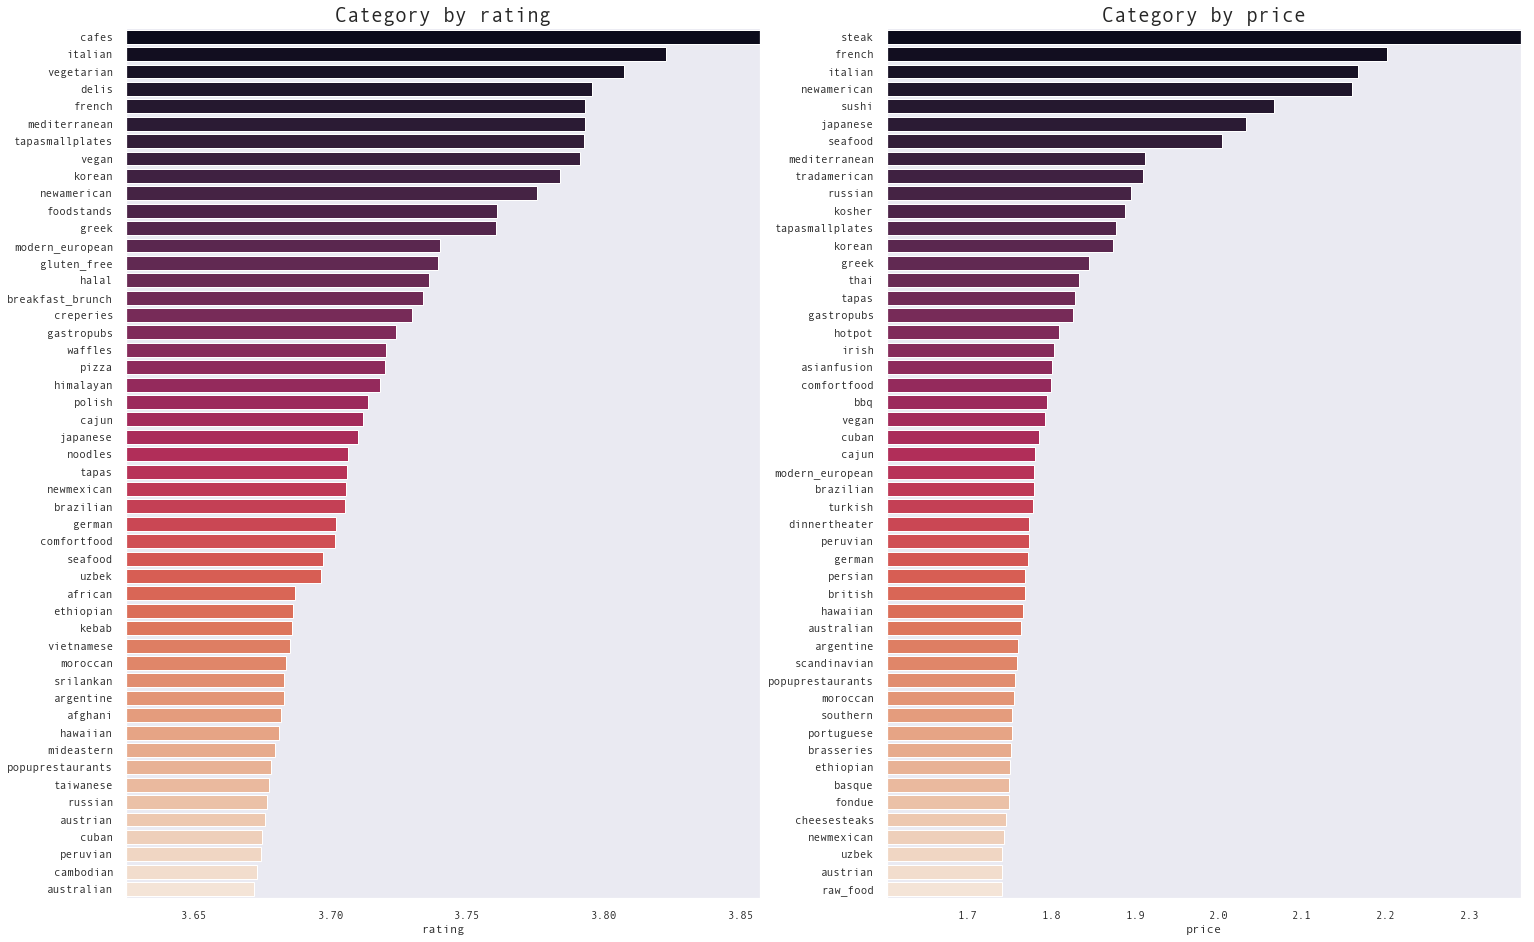

In [63]:
def bayes_avg(df,cond,col):
    v = df.groupby(cond)[col].size()
    m = df[cond].value_counts().mean()
    w = v/(v+m)
    S = w*df.groupby(cond)[col].mean() + (1-w)*df[col].mean()
    return S

n = 50
colors = sns.cubehelix_palette(n_colors=n)
cats = df.columns[df.columns.str.contains('cat_')]
cats2 = cats[df[cats].sum()>50]
cols = [['total number','review_count'],['rating','price']]
for j in range(2):
    fig,axes = plt.subplots(1,2,figsize=(25,16))
    for i,ax in enumerate(axes):
        col = cols[j][i]
        if j==0 and i==0:
            y = df[cats2].sum().sort_values(ascending=False).reset_index().rename(columns={'index':'categories',0:col})
            y['categories'] = y['categories'].str.slice(start=4)
        else:
            y = bayes_avg(df,'categories',col).reset_index().sort_values(col,ascending=False)
        y = y.iloc[:n]
        sns.barplot(data=y,x=col,y='categories',orient='h',palette='rocket',ax=ax)
        ax.set_title('Category by {}'.format(col),fontsize='20')
        ax.set_xlim([y[col].min()-y[col].std(),y[col].max()])
        ax.grid('False')
        ax.set_ylabel('')
plt.show()

Wow! A lot of this information is somewhat expected -- there are a lot of Chinese restaurants but they're not necessarily well-rated; steaks are expensive; and people generally like Italian restaurants. Perhaps a little surprising is how highly-rated cafes and vegetarian food are!

### Now let's look at some geographic information!

In [45]:
import json
with open('nyc-zip-code-tabulation-areas-polygons.geojson','r') as f:
    data = json.load(f)
    
z = df['zip'].unique()
zip_json = [i for i in data['features'] if i['properties']['postalCode'] in z]
data = {'features':zip_json}


### First, restaurant density by zip code*:

*as a function of Yelp and our scraping methods

In [78]:
import folium
l,t,zoom = [40.738, -73.91],'OpenStreetMap',11
df_zip = df.groupby(['zip']).size().reset_index()
folium_map = folium.Map(location=l,tiles=t, zoom_start=zoom)
folium_map.choropleth(geo_data=data,data=df_zip,columns=['zip', 0],
             key_on='properties.postalCode',fill_opacity = .7,fill_color='OrRd')
folium_map

As expected, most restaurants are in lower Manhattan.

### Now, for average ratings by zip, and average review count by zip

In [71]:
df_zip = bayes_avg(df,'zip','rating').reset_index()
folium_map = folium.Map(location=l,tiles=t, zoom_start=zoom)
folium_map.choropleth(geo_data=data,data=df_zip,columns=['zip', 'rating'],
             key_on='properties.postalCode',fill_opacity = .7,fill_color='OrRd')
folium_map

In [79]:
df_zip = bayes_avg(df,'zip','review_count').reset_index()
folium_map = folium.Map(location=l,tiles=t, zoom_start=zoom)
folium_map.choropleth(geo_data=data,data=df_zip,columns=['zip', 'review_count'],
             key_on='properties.postalCode',fill_opacity = .7,fill_color='OrRd')
folium_map

Wow, people definitely enjoy eating in lower Manhattan and parts of Brooklyn.

### Finally, let's look at price by zip!

In [80]:
df_zip = bayes_avg(df,'zip','price').reset_index()
folium_map = folium.Map(location=l,tiles=t, zoom_start=zoom)
folium_map.choropleth(geo_data=data,data=df_zip,columns=['zip', 'price'],
             key_on='properties.postalCode',fill_opacity = .7,fill_color='OrRd')
folium_map

Okay! So while lower Manhattan is super popular, areas like Midtown and UES/UWS have some pricer restaurants

### All right, well just out of curiosity, let's see if we can build a regression model from this information (restaurant category, price, review count, and borough) to predict mean restaurant rating

We'll try both a linear model (plain old linear regression + L2 regularization) as well as a nonlinear model (random forest regression, limiting number of trees + max depth).

In [237]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

cols = ['review_count','price']
df_rf = df[cols].join(pd.get_dummies(df['zip'])).join(pd.get_dummies(df['categories']))
df_rf['price'] = df_rf['price'].fillna(np.nanmedian(df_rf['price']))

X_train, X_test, Y_train, Y_test = train_test_split(df_rf, df['rating'], test_size=0.3)
model = Ridge(normalize=True, alpha=.1).fit(X_train,Y_train)
print('Linear regression R-squared = {}'.format(model.score(X_test,Y_test)))
      
X_train, X_test, Y_train, Y_test = train_test_split(df_rf, df['rating'], test_size=0.3)
model = RandomForestRegressor(max_depth=5,n_estimators=5).fit(X_train,Y_train)
print('Random Forest regression R-squared = {:.2f}'.format(model.score(X_test,Y_test)))


Linear regression R-squared = 0.1091644691271675
Random Forest regression R-squared = 0.06


Oh dear, these models are not fitting the data well at all. In the interest of time and space, I won't present any other variants, but let's just say that tuning various hyperparameters and trying some other models like SVR do not significantly change our findings.

### Now for the main event, it's time to scrape actual review data!

We have currently gathered around 20k restaurants in the NYC area from the Yelp API. Unfortunately, the API does not allow for mass extraction of review data, so we will have to manually scrape these data. The Yelp API outputs the URL for each restaurant's Yelp page, so using this we can iteratively comb through all reviews using the requests and bs4 modules. For practical reasons, let's focus on restaurants that have more than 500 reviews, since those are the ones that visitors are more likely to review.

In [273]:
df = pd.read_pickle('nyc_processed.pkl')
save_reviews(df,'manhattan_reviews_500.pkl'):
dfr = pd.read_pickle('manhattan_reviews_500.pkl')

print('There are {} restaurants with more than 500 reviews. A quick check against actual Yelp suggests that this makes sense.'.format(dfr['id'].nunique()))
print('\n')
print('From these restaurants, there are a total of {} reviews'.format(dfr.shape[0]))

There are 1421 restaurants with more than 500 reviews. A quick check against actual Yelp suggests that this makes sense.


From these restaurants, there are a total of 1360558 reviews


### Time to load and clean the review data.

Most importantly, we need to generate some new information from the existing data, most notably:

   1) Whether a given review comes from a resident or a visitor. To do this, location information was scraped from each reviewer/review. These data are a little noisy, but we can generally use some key words to tell if someone is from the NYC area. We try not to include residents from NY state outside of NYC.
   
   2) Similarly, we can try to extract the state that each reviewer is from.
   
   3) We are able to get the day the restaurant first appeared on yelp (proxy for grand opening) by finding the earliest review for each restaurant.
    

In [368]:
df = pd.read_pickle('nyc_processed.pkl')
w = df['review_count']/(df['review_count']+df['review_count'].mean())
df['bayes_avg'] = w*df['rating'].mean() + (1-w)*df['rating']

dfr = pd.read_pickle('manhattan_reviews_500.pkl')
dfr['ratings'] = dfr['ratings'].astype('int64')
location = dfr['location'].str.contains('Manhattan|Brooklyn|Queens|New York City|Flushing|Astoria|Bronx|New York NY',case=False)

dfr['is_local'] = location.astype('int64')
dfr['time_diff'] = dfr['dates']-pd.merge(dfr,dfr.groupby(['id'])['dates'].min().reset_index(),on='id')['dates_y']
dfr['time_diff'] = dfr['time_diff'].dt.days
dfr = dfr.join(dfr.groupby('id')['dates'].min(),on='id',rsuffix='_open')
dfr = dfr.sort_values(['id','is_local','dates']).reset_index(drop=True)
dfr['state'] = dfr['location'].str.slice(start=-2)
dfr['state'] = dfr['state'].apply(lambda x: x if x.upper()==x else 'INT')
dfr.loc[dfr['state']=='PR','state'] = 'INT'
df_both = pd.merge(dfr,df,on='id',how='left')
df_both = pd.merge(df_both,df_both.groupby('alias')['ratings'].mean().reset_index().rename(columns = {'ratings':'ratings_true'}),on='alias')


### Now, we should look at some summary statistics of ratings!


In [256]:
print('There are {0[0]} local reviews and {0[1]} visitor reviews.'.format(dfr['is_local'].value_counts().values))

There are 683498 local reviews and 677060 visitor reviews.


That's good news, the proportions between the two groups are roughly equal. Good thing we chose such a popular tourist city!

### Let's plot the rating differences between locals and tourists.

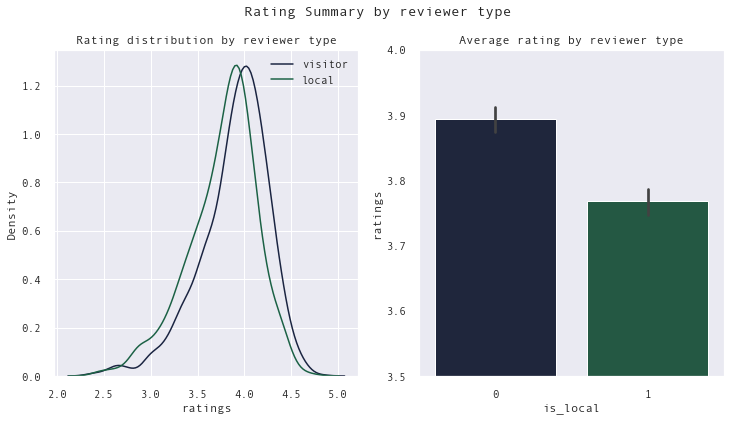

In [82]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
fig.suptitle('Rating Summary by reviewer type')
sns.distplot(dfr[dfr['is_local']==False].groupby('id')['ratings'].mean(),hist=False,ax=ax[0],label='visitor')
sns.distplot(dfr[dfr['is_local']==True].groupby('id')['ratings'].mean(),hist=False,ax=ax[0],label='local')
ax[0].set_title('Rating distribution by reviewer type')
ax[0].set_ylabel('Density')
ax[0].legend(['visitor','local'])
sns.barplot(x='is_local',y='ratings',data=dfr.groupby(['is_local','id'])['ratings'].mean().reset_index(),ax=ax[1])
ax[1].set_ylim(3.5,4)
ax[1].set_title('Average rating by reviewer type')
ax[1].grid(False)
plt.show()

It's clear from this that ratings are on average higher for visitors compared to locals, which is perhaps not too surprising.

Next, we want to chart how this pattern plays out over time. Essentially one hypothesis would be that the older a restaurant is, the more likely it is that it would be popular and attract visitors; visitors would also be more likely to rate these restaurants higher due to reputation. Let's see how that plays out!

### Now let's explicitly look at which categories tend to be more popular with tourists

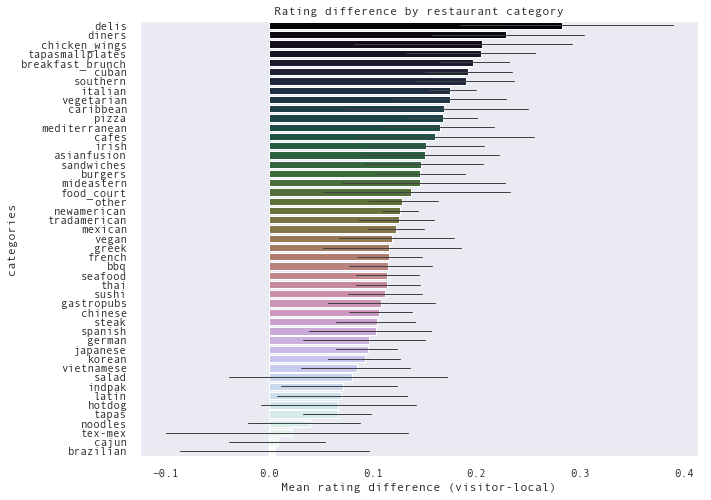

In [50]:
fig,ax = plt.subplots(figsize=(10,8))
cats_ranked = df_rest.groupby('categories')['diff_x'].mean().reset_index().sort_values('diff_x',ascending=False)

sns.barplot(x='diff_x',y='categories',data=df_rest,palette='cubehelix',errwidth=1,orient='h',order=cats_ranked['categories'])
ax.set_xlabel('Mean rating difference (visitor-local)')
ax.grid(False)
ax.set_title('Rating difference by restaurant category')
plt.show()

Delis and diners are the top two most well-rated categories of restaurants for visitors relative to residents. In particular, "delis" makes sense -- this alongside pizza is what NYC is known for! Incidentally, pizza is fairly highly ranked as well. However, these are error bars show that our standard deviations are extremely high, and offline t-tests don't nec

### Okay, now let's do some interactive plotting.

In [51]:
l= []
N= cats_ranked['categories'].nunique()
colors = plotly_colors(N)

for i,c in enumerate(cats_ranked['categories'].unique()):
    tmp = df_rest[df_rest['categories']==c]
    trace0= go.Scatter(x=tmp['num_pctch'],y=tmp['diff_x'],name=c,mode= 'markers',
        marker=dict(size=6,line= dict(width=1),color= colors[i],opacity=.8),text= tmp['alias'])
    l.append(trace0);
l.append(go.Scatter(name='',x=[50,50],y=[df_rest['diff_x'].min()-.1,df_rest['diff_x'].max()+.1],line=dict(color='black',width=.5),mode='lines'))
layout= go.Layout(title='Restaurant ratings, visitor vs. local',hovermode='closest', font=dict(family='Andale Mono, monospace'),
    xaxis=dict(title='% reviews visitor'),yaxis=dict(title='rating difference (visitor-local)'),showlegend= True)
fig= go.Figure(data=l, layout=layout)
py.iplot(fig)

We plot the percent of reviews generated by visitors vs. locals for each restaurant on the x-axis and the mean difference in rating on the y axis. Each point is color coded by the category. Hover over each point to look at the particular restaurant!

We can also see that there's a slight correlation between these two variables: restaurants that are proportionally more frequented by visitors are also more likely to be more enjoyed by visitors relative to locals

### Where are all these restaurants that visitors are reviewing?

In [207]:
colors = sns.cubehelix_palette(n_colors=50)
l,z,t = [40.738, -73.91], 12, 'CartoDB dark_matter'
hexc = ['#%02x%02x%02x' % (int(c[0]*255),int(c[1]*255),int(c[2]*255)) for c in colors]
col = 'num_pctch'
cm = np.linspace(df_rest[col].max(),df_rest[col].min(),50)

folium_map = folium.Map(location=l,zoom_start=z,tiles=t)
for index,row in df_rest.sort_values(col).iterrows():
    color_idx = np.argmin(np.abs(cm-row[col]))
    folium.Circle( location=[row['latitude'],row['longitude']], fill=True,
                      color=hexc[color_idx], popup='{}: {:.1f}% visitor'.format(row['name'],row[col]),radius=1).add_to(folium_map)


display(folium_map)

This map shows, for each restaurant, the percentage of people who reviewed the restaurant that are visitors. Perhaps not surprising, restaurants in Midtown tend to be particularly heavily populated by tourists.

### Do tourists prefer restaurants in a particular neighborhood relative to locals?

In [251]:
col = 'diff_x'
cm = np.linspace(df_rest[col].max(),df_rest[col].min(),50)

folium_map = folium.Map(location=l,zoom_start=z,tiles=t)
for index,row in df_rest.sort_values(col).iterrows():
    color_idx = np.argmin(np.abs(cm-row[col]))
    folium.Circle( location=[row['latitude'],row['longitude']], fill=True,
                      color=hexc[color_idx], popup='{}: {:.1f} visitor-local'.format(row['name'],row[col]),radius=1).add_to(folium_map)


display(folium_map)

Our findings show... not particularly. Tourists just really like bagels and restaurants that were featured in The Sopranos.

### Are all tourists the same?

In [67]:
df_state = bayes_avg(df_both,'state','rating').reset_index()
df_state = pd.merge(df_state,df_both['state'].value_counts().reset_index().rename(columns={'state':'count','index':'state'}),on='state')
data = [ dict(type='choropleth', colorscale = 'Picnic',autocolorscale = False,
        locations = df_state['state'], z = df_state['rating'], locationmode = 'USA-states',
        text = df_state['count'], marker = dict(line = dict(color='white',width=2)), 
        colorbar = dict(title = 'Average rating')) ]

layout = dict(title = 'Average rating by state',font=dict(family='Andale Mono, monospace'),
        geo = dict(scope='usa',projection=dict(type='albers usa')))
    
fig = dict( data=data, layout=layout )
py.iplot(fig)


This seems cool... but look at the color scale! Some quick t-tests show that actually, there is very little variation

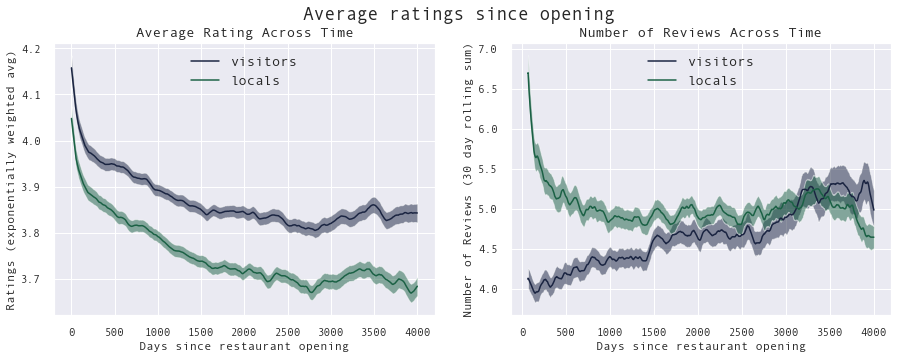

In [44]:
cat = 'price'
all_ts,all_count=return_ts(df_both,cat,0,compare='gt')
plot_ratings(all_ts,all_count,cat,0,title='Average ratings since opening')
plt.show()

That's pretty interesting! Across time, visitors are uniformly reviewing restaurants more favorably than locals, though both groups tend to lower their ratings over time.

Given these findings, our hypothesis is thus: locals are much more likely to review a restaurant when it just opened compared to visitors, but over time tourists "find out" about them, and over time perhaps some positive feedback here transforms the makeup of the kind of people who visit or review there.

Let's do some further digging and test if this hypothesis is true! If it's true, we expect if we divvy up restaurants by the year they opened, we would find this trend among all years: early years after opening are dominated by local reviewers, and later years shifting to visitors.


In [342]:
def plotly_colors(n):
    return ['rgb({0[0]},{0[1]},{0[2]})'.format(i) for i in sns.color_palette("cubehelix", n)]
    
    
l,l2=[],[]
r = range(2005,2018)
colors = plotly_colors(len(r)+5)
for i,yr in enumerate(r):
    min_date = pd.to_datetime('0101{}'.format(yr),format='%m%d%Y')
    max_date = pd.to_datetime('0101{}'.format(yr+1),format='%m%d%Y')
    all_ts,all_count=return_ts(df_both,'dates_open',[min_date,max_date],compare='gtlt')
    cdiff = np.squeeze(np.diff(np.nanmean(all_count[:,:,:-365],axis=1),axis=0))
    trace0= go.Scatter(x=list(range(0,-cdiff.shape[0],-1)),y=cdiff,name=yr,mode='lines',
                       opacity=.75,line=dict(color=colors[i], width=.5), text=yr)
    l.append(trace0)
    tdiff = np.squeeze(np.diff(np.nanmean(all_ts[:,:,:-365],axis=1),axis=0))
    trace1= go.Scatter(x=list(range(0,-tdiff.shape[0],-1)),y=tdiff,name=yr,mode='lines',
                       opacity=.75,line=dict(color=colors[i], width=.5), text=yr)
    l2.append(trace1)

layout= go.Layout(title='# Review difference, local vs. visitor',hovermode='closest', font=dict(family='Andale Mono, monospace'),
    xaxis=dict(title='Days since today'),yaxis=dict(title='Review difference (local-visitor)'),showlegend=True)


fig= go.Figure(data=l, layout=layout)
py.iplot(fig,filename='count_diff')


The draw time for this plot will be slow for clients without much RAM.


Actually, our hypothesis is totally wrong! If we plot the difference between # of local vs. visitor reviews from starting today, aggregating restaurants by the year they opened, old restaurants actually had relatively more visitor reviews than local reviews whenever the first reviews began. It's newer restaurants that show a bias towards locals at opening time.

Given this information, our new interpretation of the data must be related to the Yelp service itself, which began in 2004 and is headquartered in San Francisco, where the majority of Yelpers must have lived during that time. So, our plots are likely a function of the popularity of Yelp itself across the country: over time, Yelp became more widely used among New Yorkers.

Well, this is not quite the insight we were hoping for. But not so fast! We have currently aggregated over all of the restaurant data we have. What if we just take a look at some special cases -- for example, restaurants that are most canonized and have the highest reviews?

To do that, let's first plot what those are!

In [114]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import plotly.graph_objs as go

df_bydate = df_both.groupby('alias')['name','dates_open','review_count','ratings_true'].first().reset_index().sort_values('dates_open')
data = [go.Scatter(x=df_bydate['dates_open'],y=df_bydate['review_count'],mode= 'markers',
        marker=dict(size=6,line= dict(width=1),color= 'red',opacity=.5),text= df_bydate['name'])]

layout= go.Layout(title='Restaurant age vs review count',hovermode='closest', font=dict(family='Andale Mono, monospace'),
    xaxis=dict(title='First review'),yaxis=dict(title='Review count'))
fig= go.Figure(data=data, layout=layout)
py.iplot(fig)



Here we've sorted by earliest reviews posted on Yelp. Anecdotally, we should notice that many of these restaurants probably pre-date the date of their Yelp review by some time. For example, the extremely famous "Katz's Delicatessan" has existed "since 1888" according to their website (and was famously featured in the 1989 movie "When Harry Met Sally"), but the first review went up in July, 2005. This is, of course, a function of how long Yelp has existed.

In [356]:
r = 4000
all_ts,all_count=return_ts(df_both[df_both['review_count']>r],'price',0,compare='gt')
names = df_both.loc[df_both['review_count']>r,'name'].unique()
cdiff = np.squeeze(np.diff(all_count,axis=0))
colors = plotly_colors(all_count.shape[1]+3)
l = []
for i in range(all_count.shape[1]):    
    trace0= go.Scatter(x=list(range(0,-cdiff.shape[1],-1)),y=cdiff[i,:],name=names[i],mode='lines',
                       opacity=.75,line=dict(color=colors[i], width=.5), text=yr)
    l.append(trace0)
    
layout= go.Layout(title='# Review difference, local vs. visitor',hovermode='closest', font=dict(family='Andale Mono, monospace'),
    xaxis=dict(title='Days since today'),yaxis=dict(title='Review difference (local-visitor)'),showlegend=True)

fig= go.Figure(data=l, layout=layout)
py.iplot(fig,filename='pop_ts')

The draw time for this plot will be slow for clients without much RAM.


### Finally, let's perform some decoding!

Let's see whether or not we can use the reviews to decode whether someone is a resident or a tourist, and what words they tend to use. First, let's tokenize and stem each review.

In [4]:
df_both['reviews'] = df_both['reviews'].apply(lambda x: tokenize(x))
df_rohc = df_both[['alias','reviews','is_local']]
idx = df_rohc[df_rohc['reviews'].str.len()==0].index
df_rohc = df_rohc.drop(labels=idx,axis=0).reset_index(drop=True)
df_rohc.to_pickle('nyc_reviews_stemmed.pkl')

Now, let's use the bag of words approach and apply one of the simplest text classification algorithms: Naive Bayes!

We have over a million reviews and each review can have upwards of a hundred words -- that's going to an enormous feature matrix. As a first pass, let's try to build models for each restaurant separately, so that we get a distribution of predictions across restaurants

In [118]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score

def ohc_convert(df):
    return pd.concat((df.drop('reviews', 1),pd.get_dummies(pd.DataFrame(df['reviews'].tolist()).stack()).astype(int).sum(level=0)),axis=1)


def text_classification(df, classifier='nb'):
    cols = df_rohc['alias'].unique()
    c = len(cols)
    acc, prec, rec = np.zeros(c),np.zeros(c),np.zeros(c)
    feat1,feat2 = [],[]
    for i,col in enumerate(cols):
        rest = df_rohc[df_rohc['alias']==col].reset_index(drop=True)
        prop = rest['is_local'].value_counts().reset_index()
        a = rest[rest['is_local']==prop['index'].iloc[prop['is_local'].idxmin()]]
        b = rest[rest['is_local']==prop['index'].iloc[prop['is_local'].idxmax()]].sample(n=prop.min()['is_local'])
        rest = pd.concat((a,b),axis=0).reset_index(drop=True)
        X = ohc_convert(rest).drop('alias',1)
        Y = X.pop('is_local')
        X_train, X_test, Y_train, Y_test = train_test_split(X.fillna(0).as_matrix(), Y.as_matrix(), test_size=0.3)    

        if classifier=='nb':
            model = BernoulliNB().fit(X_train,Y_train)
            Y_pred = model.predict(X_test)
            diff = np.diff(model.feature_log_prob_,axis=0)
            f1,f2 = X.columns[np.argmax(diff)],X.columns[np.argmin(diff)]
            
        elif classifier=='svm':
            model = LinearSVC().fit(X_train,Y_train)
            Y_pred = model.predict(X_test)
            f1 = X.columns[np.argmax(model.coef_)]
            f2 = f1
            
        feat1.append(f1)
        feat2.append(f2)   
        acc[i], prec[i], rec[i] = accuracy_score(Y_test,Y_pred), precision_score(Y_test,Y_pred), recall_score(Y_test,Y_pred)
        print('{} {}'.format(f1,acc[i]))
            
    df_nb = pd.DataFrame({'alias':cols,'accuracy':acc,'precision':prec,'recall':rec,'local':feat1,'visitor':feat2}) 
    df_nb['F1'] = 2*(df_nb['precision']*df_nb['recall'])/(df_nb['precision']+df_nb['recall'])
    return df_nb

# df_nb = text_classification(df_rohc)

### Plotting results

Okay, let's see how we did by plotting distributions of overall accuracy, precision/recall/F1. 

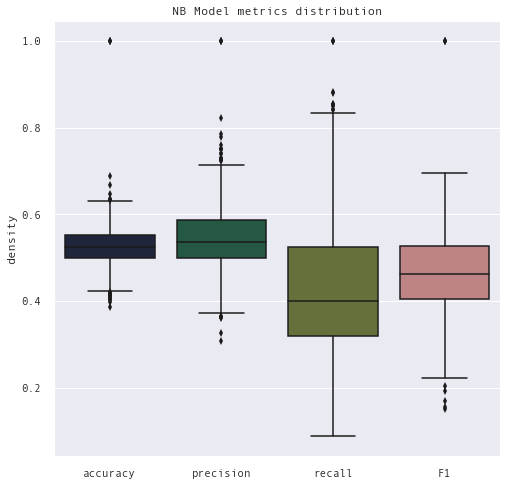

In [88]:
fig,ax = plt.subplots(figsize=(8,8))


sns.boxplot(x='level_1',y=0,data=df_nb[['accuracy','precision','recall','F1']].stack().reset_index(),orient='v')
ax.set_ylabel('density')
ax.set_xlabel('')
ax.set_title('NB Model metrics distribution')
plt.show()  
            

The good news is that on average we are classifying higher than 50%. The bad news is that it's only about 2% higher.

In [85]:
print('These words have relative higher probabilities in locals:')
df_nb['local'].value_counts().head(10)

These words have relative higher probabilities in locals


elsewher        10
anyway          10
sometim         10
friday           9
neighborhood     8
comfort          8
mention          8
terribl          7
take             7
quickli          7
Name: local, dtype: int64

In [86]:
print('These words have relative higher probabilities in visitors:')
df_nb['visitor'].value_counts().head(10)

These words have relative higher probabilities in visitors:


daughter      12
husband       11
visit         10
stay          10
fabul          7
across         7
corner         6
stop           6
outstand       6
california     6
Name: visitor, dtype: int64